In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageFilter
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

from sklearn.cluster import KMeans
from skimage.measure import label
from skimage.measure import label, regionprops
from scipy.ndimage import binary_dilation

In [2]:
class Load_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.TIF'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
class Preprocess:
    def __call__(self, image):
        sample = np.array(image)
        sample = cv2.normalize(sample, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        processed_image = Image.fromarray(sample).convert('RGB')
        return processed_image

In [4]:
transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((2048, 2048)),
    transforms.ToTensor(),
])

In [5]:
dataset = Load_data(root_dir='images/normal', transform=transform)
train_size = 9
test_size = 2
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train = DataLoader(train_dataset, batch_size=1, shuffle=True)
test = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
pretrained_encoder = models.vgg16(weights="IMAGENET1K_V1")
encoder = nn.Sequential(*list(pretrained_encoder.features.children())[:-1])

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for clustering
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)

autoencoder.load_state_dict(torch.load("autoencoder_model.pth"))
autoencoder.eval()
print("Model loaded successfully")

Model loaded successfully


In [31]:
# Obtain a sample image and move it to the device
sample_img = next(iter(test))
sample_img = sample_img.to(device)

# Use only the encoder to get the latent representation
with torch.no_grad():
    latent_representation = autoencoder.encode(sample_img)

latent_representation_image = latent_representation[0].cpu().numpy()

print("Latent Representation Shape:", latent_representation.shape)

Latent Representation Shape: torch.Size([1, 8388608])


In [ ]:
sample_img = next(iter(test))
sample_img = sample_img.to(device)

with torch.no_grad():
    latent_space = encoder(sample_img)

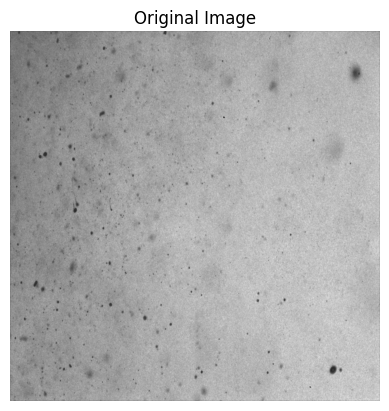

In [12]:
def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

display_image(sample_img[0], title="Original Image")
#display_image(reconstructed_img[0], title="Reconstructed Image")

In [9]:
#Flatten the latent space
latent_space_flat = latent_space.view(-1, latent_space.shape[1])  # Flatten [B, C, H, W] -> [N, C]
print("Shape of latent space:", latent_space_flat.shape)

Shape of latent space: torch.Size([16384, 512])


In [13]:
print("Encoder output shape:", latent_space.shape)  # Should be [B, 512, H, W]

Encoder output shape: torch.Size([1, 512, 128, 128])


In [27]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjust eps and min_samples as needed
cluster_labels = dbscan.fit_predict(latent_space_flat.cpu())

# Summarize clustering results
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise_points = list(cluster_labels).count(-1)

print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise_points}")

Number of clusters found: 56
Number of noise points: 14105


In [28]:
import numpy as np
from collections import Counter

# Convert cluster labels to a numpy array if not already
cluster_labels_np = np.array(cluster_labels)

# Count the occurrences of each cluster label
cluster_counts = Counter(cluster_labels_np)

# Exclude noise points (-1) if present
if -1 in cluster_counts:
    print(f"Noise points: {cluster_counts[-1]}")
    cluster_counts.pop(-1)

# Dynamically determine the range of cluster IDs
max_cluster_id = max(cluster_counts.keys())
print(f"Max cluster ID: {max_cluster_id}")

# Print the number of points in each cluster
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} points")

# Calculate the total number of points in a dynamic range (e.g., cluster 1 to max_cluster_id)
range_start = 1  # Adjust as needed
range_end = max_cluster_id  # Dynamic upper bound

# Sum points in the range [range_start, range_end]
total_points_in_range = sum(
    count for cluster, count in cluster_counts.items() if range_start <= cluster <= range_end
)
print(f"Total number of points in clusters {range_start} to {range_end}: {total_points_in_range}")


Noise points: 14105
Max cluster ID: 55
Cluster 0: 2142 points
Cluster 1: 2 points
Cluster 2: 4 points
Cluster 3: 3 points
Cluster 4: 5 points
Cluster 5: 2 points
Cluster 6: 6 points
Cluster 7: 3 points
Cluster 8: 2 points
Cluster 9: 2 points
Cluster 10: 2 points
Cluster 11: 4 points
Cluster 12: 3 points
Cluster 13: 3 points
Cluster 14: 2 points
Cluster 15: 2 points
Cluster 16: 3 points
Cluster 17: 3 points
Cluster 18: 2 points
Cluster 19: 6 points
Cluster 20: 2 points
Cluster 21: 2 points
Cluster 22: 3 points
Cluster 23: 2 points
Cluster 24: 2 points
Cluster 25: 2 points
Cluster 26: 3 points
Cluster 27: 3 points
Cluster 28: 2 points
Cluster 29: 2 points
Cluster 30: 2 points
Cluster 31: 2 points
Cluster 32: 3 points
Cluster 33: 2 points
Cluster 34: 2 points
Cluster 35: 2 points
Cluster 36: 3 points
Cluster 37: 2 points
Cluster 38: 2 points
Cluster 39: 2 points
Cluster 40: 2 points
Cluster 41: 2 points
Cluster 42: 2 points
Cluster 43: 2 points
Cluster 44: 2 points
Cluster 45: 3 points
Cl

In [14]:
def visualize_clusters(cluster_labels, latent_shape, original_shape):
    """
    Visualize DBSCAN clusters by mapping them back to the original image dimensions.

    Parameters:
    - cluster_labels: Cluster labels from DBSCAN (flattened, 1D array)
    - latent_shape: Tuple (H, W) of the latent space dimensions
    - original_shape: Tuple (H, W) of the original image dimensions

    Returns:
    - clustered_image_resized: Cluster visualization resized to original dimensions
    """
    import cv2
    import matplotlib.pyplot as plt

    # Reshape cluster labels to latent space dimensions
    H, W = latent_shape
    cluster_labels_reshaped = cluster_labels.reshape(H, W)

    # Resize to match original image dimensions
    original_height, original_width = original_shape
    clustered_image_resized = cv2.resize(cluster_labels_reshaped, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Visualize
    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image_resized, cmap="viridis")
    plt.colorbar()
    plt.title("Cluster Visualization")
    plt.show()

    return clustered_image_resized

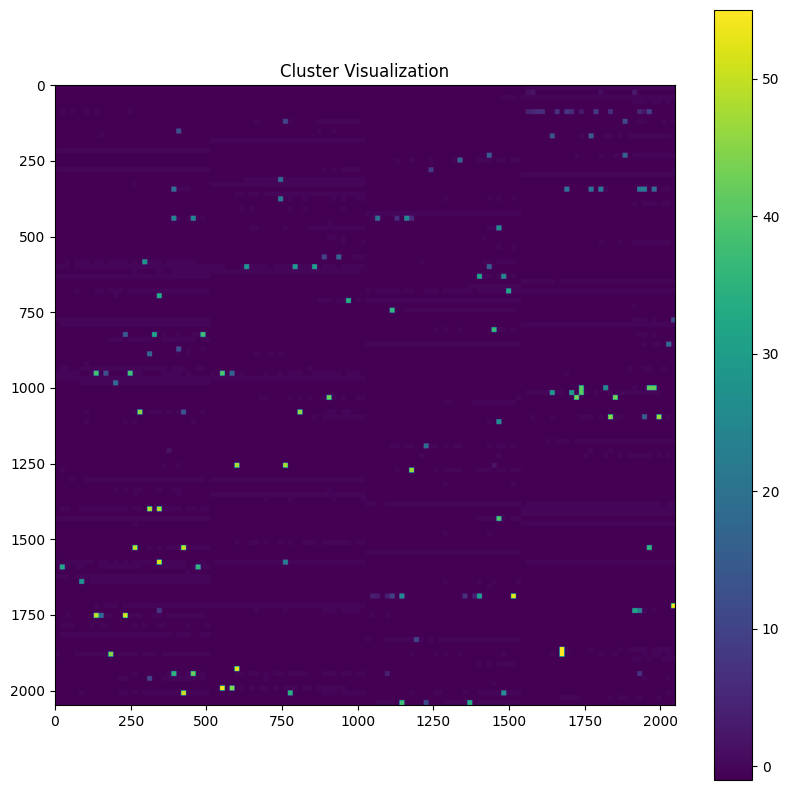

In [29]:
# Assuming cluster_labels is the output from DBSCAN
latent_shape = (128, 128)  # From encoder output spatial dimensions
original_shape = (2048, 2048)  # Replace with your original image size

clustered_image = visualize_clusters(
    cluster_labels,  # DBSCAN output
    latent_shape,    # Latent space dimensions
    original_shape   # Original image dimensions
)

In [35]:
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import matplotlib.patches as patches
import numpy as np
import cv2

def visualize_particles_on_original_image(original_img, cluster_labels, latent_shape, original_shape):
    """
    Visualize detected clusters on the original image with bounding boxes.

    Parameters:
    - original_img: Tensor of the original image (C, H, W)
    - cluster_labels: Flattened array of cluster labels from DBSCAN
    - latent_shape: Tuple (H, W) representing the latent space spatial dimensions
    - original_shape: Tuple (H, W) representing the original image dimensions

    Returns:
    - None
    """
    # Reshape cluster labels back to latent space dimensions
    cluster_map = cluster_labels.reshape(latent_shape)

    # Resize the cluster map to match the original image dimensions
    original_height, original_width = original_shape
    cluster_map_resized = cv2.resize(
        cluster_map.astype(np.uint8), (original_width, original_height), interpolation=cv2.INTER_NEAREST
    )

    # Label the clusters for region property extraction
    labeled_clusters = label(cluster_map_resized, connectivity=1)

    # Convert the image to a NumPy array for plotting
    original_img_np = original_img.permute(1, 2, 0).cpu().numpy()

    # Plot the original image
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(original_img_np, cmap="gray")
    ax.set_title("Nanoparticle Clusters on Original Image")

    # Find and draw bounding boxes for each detected particle region
    for region in regionprops(labeled_clusters):
        # Ensure the region has a non-zero area
        if region.area > 0:
            # Get bounding box coordinates (min row, min col, max row, max col)
            minr, minc, maxr, maxc = region.bbox
            # Draw the rectangle around the particle region
            rect = patches.Rectangle((minc, minr), maxc - minr, maxr - minr, 
                                      linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Optionally, add a label for each particle
            ax.text(minc, minr, f"ID: {region.label}", color="yellow", fontsize=8)

    plt.show()

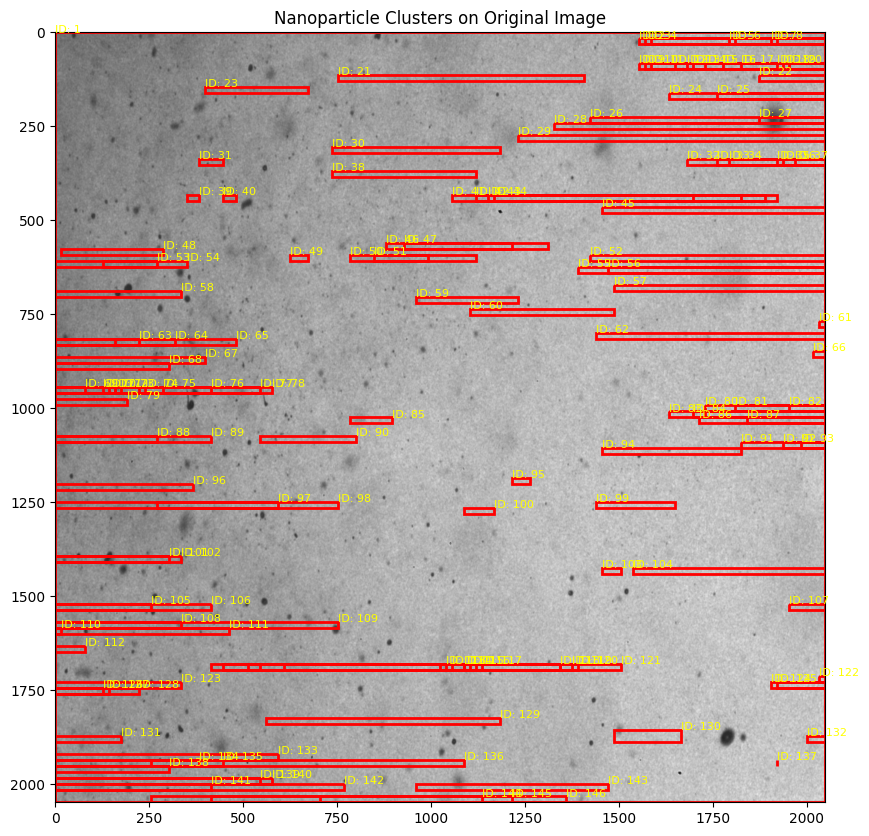

In [36]:
latent_shape = (128, 128)  # Latent space dimensions from encoder
original_shape = (2048, 2048)  # Original image dimensions (H, W)

# Call the function
visualize_particles_on_original_image(
    sample_img[0],       # Original image tensor
    cluster_labels,      # Cluster labels from DBSCAN
    latent_shape,        # Latent space shape
    original_shape       # Original image shape
)

In [29]:
# Resize the reconstructed image
smaller_img = F.interpolate(reconstructed_img, size=(256, 256), mode="bilinear", align_corners=False)
smaller_img_flat = smaller_img.permute(0, 2, 3, 1).reshape(-1, smaller_img.shape[1])

print(f"Smaller image shape: {smaller_img_flat.shape}")

Smaller image shape: torch.Size([65536, 3])


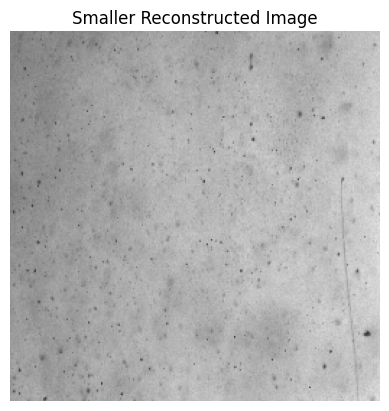

In [30]:
display_image(smaller_img[0], title="Smaller Reconstructed Image")